
Rahul Madhogarhia (CS24MTECH12004)

Ankush Chhabra (CS24MTECH14004)

Chalasani Vineeth (CS24MTECH11023)

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# 1. Load and preprocess data
df = pd.read_excel("data.xlsx")
scaler = MinMaxScaler()
data = scaler.fit_transform(df.select_dtypes(include=[np.number]))
data_tensor = torch.tensor(data, dtype=torch.float32)

dataset = TensorDataset(data_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

# 2. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3. Model definitions
class Generator(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, dim),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)

# 4. Gradient penalty function
def gradient_penalty(critic, real, fake, device):
    batch_size, dim = real.size()
    # sample interpolation
    α = torch.rand(batch_size, 1, device=device).expand_as(real)
    interp = (α * real + (1 - α) * fake).requires_grad_(True)
    # critic scores
    score = critic(interp)
    grads = autograd.grad(
        outputs=score,
        inputs=interp,
        grad_outputs=torch.ones_like(score),
        create_graph=True,
        retain_graph=True
    )[0]
    grads = grads.view(batch_size, -1)
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# 5. Hyperparameters and initialization
input_dim = data_tensor.shape[1]
G = Generator(input_dim).to(device)
C = Critic(input_dim).to(device)

lr = 1e-3
beta1, beta2 = 0.0, 0.9
g_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
c_opt = torch.optim.Adam(C.parameters(), lr=lr, betas=(beta1, beta2))

λ_gp = 10       # gradient penalty weight
n_critic = 5    # critic steps per generator step
epochs = 2000

# 6. Training loop
for epoch in range(epochs):
    for i, (real_batch,) in enumerate(loader):
        real_batch = real_batch.to(device)

        # --- Train Critic ---
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), input_dim, device=device)
            fake_batch = G(z).detach()

            c_real = C(real_batch).mean()
            c_fake = C(fake_batch).mean()
            gp = gradient_penalty(C, real_batch, fake_batch, device)

            c_loss = -(c_real - c_fake) + λ_gp * gp

            c_opt.zero_grad()
            c_loss.backward()
            c_opt.step()

        # --- Train Generator ---
        z = torch.randn(real_batch.size(0), input_dim, device=device)
        fake_batch = G(z)
        g_loss = -C(fake_batch).mean()

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    # Logging
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}]  "
              f"C Loss: {c_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

# 7. Generate and save synthetic data
G.eval()
with torch.no_grad():
    z = torch.randn(1000, input_dim, device=device)
    syn = G(z).cpu().numpy()
syn = scaler.inverse_transform(syn)

synthetic_df = pd.DataFrame(syn, columns=df.select_dtypes(include=[np.number]).columns)
synthetic_df.to_excel("synthetic_data.xlsx", index=False)
print(" Synthetic data saved to synthetic_data.xlsx")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [100/2000]  C Loss: -0.0136  G Loss: 0.5752
Epoch [200/2000]  C Loss: 0.0264  G Loss: -0.2646
Epoch [300/2000]  C Loss: 0.0091  G Loss: -0.0330
Epoch [400/2000]  C Loss: -0.0013  G Loss: -1.9928
Epoch [500/2000]  C Loss: 0.0367  G Loss: -0.0468
Epoch [600/2000]  C Loss: 0.0047  G Loss: 0.9010
Epoch [700/2000]  C Loss: 0.0094  G Loss: -0.5501
Epoch [800/2000]  C Loss: 0.0083  G Loss: -2.0629
Epoch [900/2000]  C Loss: 0.0408  G Loss: -2.5586
Epoch [1000/2000]  C Loss: -0.0091  G Loss: -0.8582
Epoch [1100/2000]  C Loss: -0.0305  G Loss: 3.3281
Epoch [1200/2000]  C Loss: 0.0224  G Loss: 4.6491
Epoch [1300/2000]  C Loss: 0.0211  G Loss: 2.1185
Epoch [1400/2000]  C Loss: -0.0038  G Loss: 0.4501
Epoch [1500/2000]  C Loss: -0.0033  G Loss: -1.7890
Epoch [1600/2000]  C Loss: 0.0030  G Loss: -2.5414
Epoch [1700/2000]  C Loss: 0.0275  G Loss: -2.9608
Epoch [1800/2000]  C Loss: -0.0450  G Loss: 0.0367
Epoch [1900/2000]  C Loss: -0.0208  G Loss: -0.9766
Epoch [2000/2000]  C Loss: -0.0083  G L

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


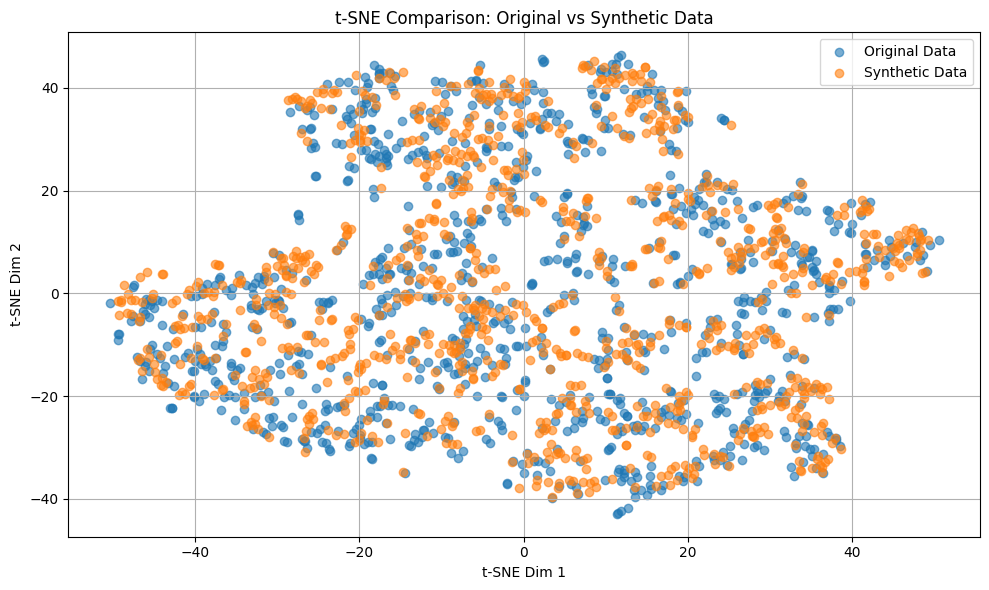

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Combine original and synthetic data for comparison
original_sample = data[:1000]  # Sample for fair comparison
synthetic_sample = scaler.transform(synthetic_df.sample(n=1000, random_state=42))

# Run t-SNE on both
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
combined = np.vstack([original_sample, synthetic_sample])
tsne_results = tsne.fit_transform(combined)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:1000, 0], tsne_results[:1000, 1], label='Original Data', alpha=0.6)
plt.scatter(tsne_results[1000:, 0], tsne_results[1000:, 1], label='Synthetic Data', alpha=0.6)
plt.title('t-SNE Comparison: Original vs Synthetic Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("/mnt/data/data_comparison_tsne.png")
plt.show()

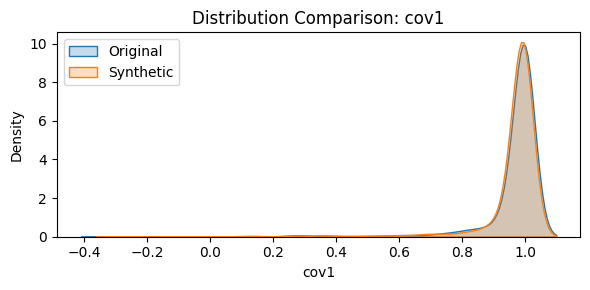

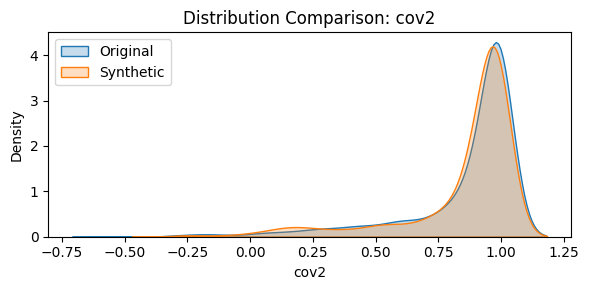

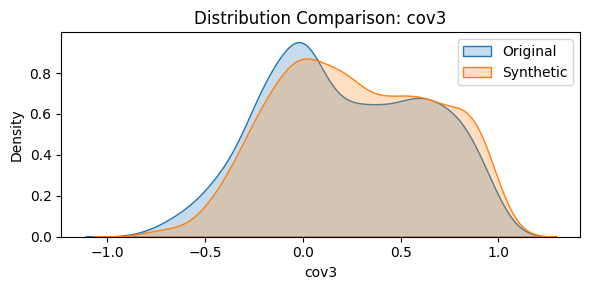

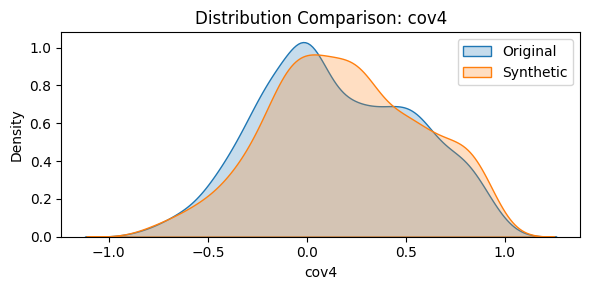

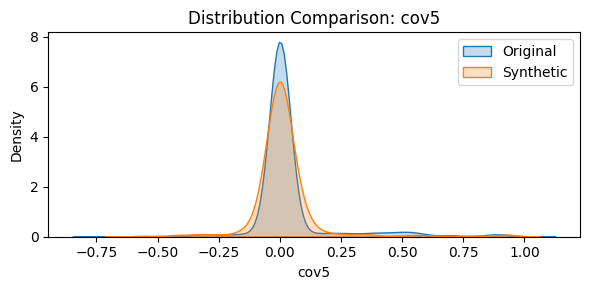

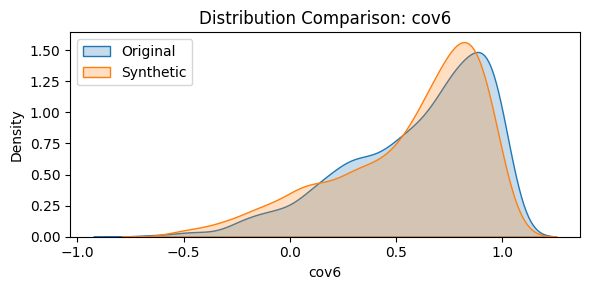

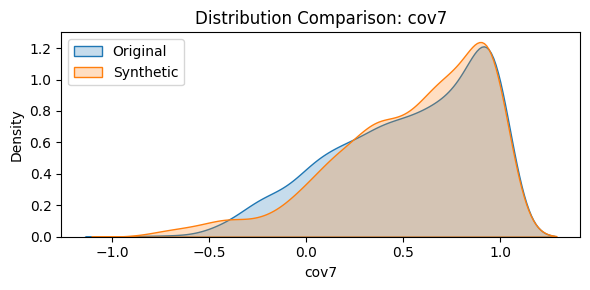

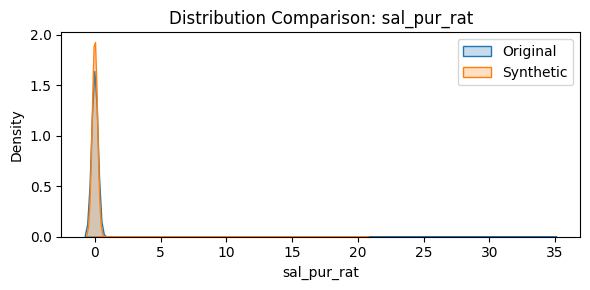

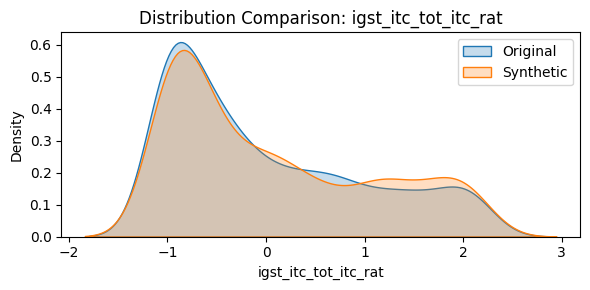

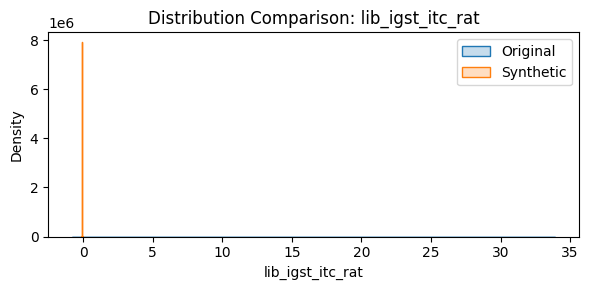

In [5]:
import seaborn as sns

for col in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(df[col], label='Original', fill=True)
    sns.kdeplot(synthetic_df[col], label='Synthetic', fill=True)
    plt.title(f'Distribution Comparison: {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

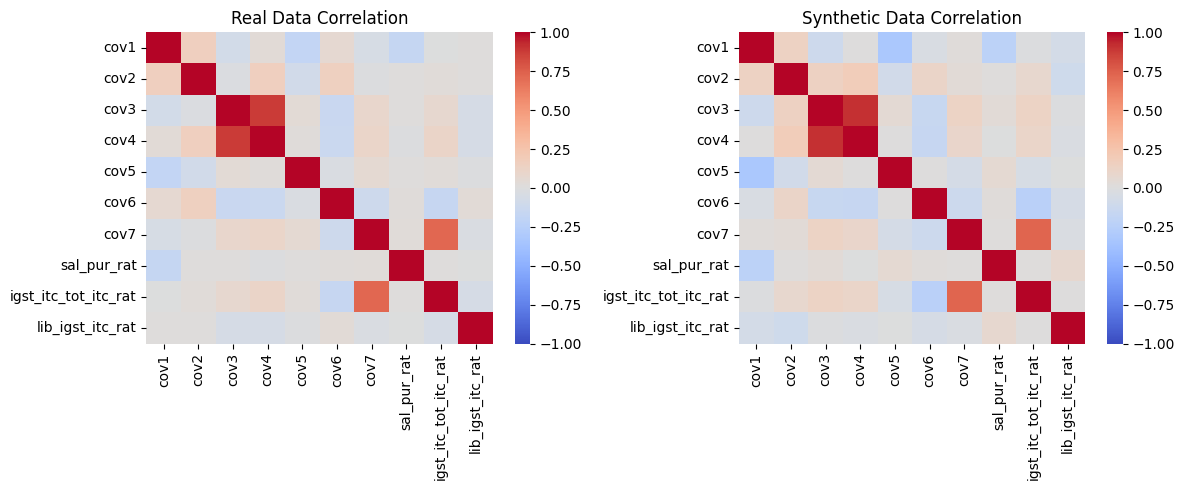

In [6]:
import seaborn as sns

real_corr = df.corr()
synthetic_corr = synthetic_df.corr()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(real_corr, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Real Data Correlation')

sns.heatmap(synthetic_corr, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Synthetic Data Correlation')
plt.tight_layout()
plt.show()

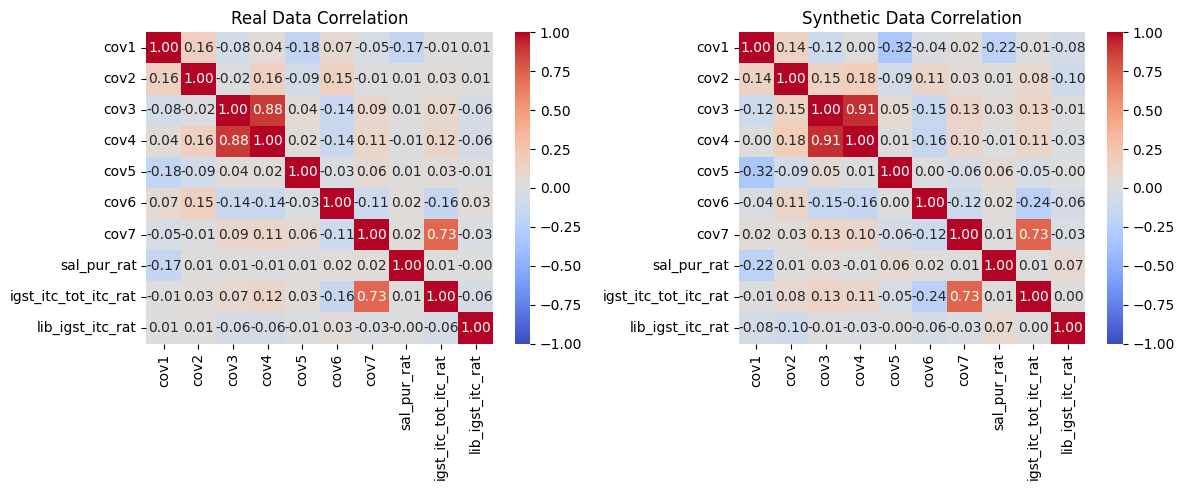


 Correlation similarity score between real and synthetic data: 98.71%


In [7]:
import seaborn as sns

real_corr = df.corr()
synthetic_corr = synthetic_df.corr()

# Plot side-by-side heatmaps with annotations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(real_corr, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
axes[0].set_title('Real Data Correlation')

sns.heatmap(synthetic_corr, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
axes[1].set_title('Synthetic Data Correlation')

plt.tight_layout()
plt.show()

# Flatten correlation matrices and compute similarity score
real_flat = real_corr.values.flatten()
synthetic_flat = synthetic_corr.values.flatten()
similarity = np.corrcoef(real_flat, synthetic_flat)[0, 1] * 100

print(f"\n Correlation similarity score between real and synthetic data: {similarity:.2f}%")
